In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
from datasets import load_from_disk
import distribution_inference.models.asr as models_asr
import evaluate
from distribution_inference.training.utils import load_model
import numpy as np
import torch as ch
from tqdm import tqdm

from dataclasses import dataclass
from typing import Any, List, Dict, Union

from transformers import WhisperFeatureExtractor
from transformers import WhisperTokenizerFast
from transformers import WhisperProcessor
from transformers import WhisperForConditionalGeneration

from audiomentations import Compose, AddGaussianNoise, PitchShift, AirAbsorption, TanhDistortion
import IPython.display as ipd

import evaluate

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 150

2023-06-16 10:30:40.739608: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-06-16 10:30:40.789286: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-16 10:30:43.188312: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
base_data_dir = "/p/adversarialml/as9rw/datasets/librispeech/"
small_data_sample = load_from_disk(os.path.join(base_data_dir, "processed", "adv", "audit_subjects"))

In [169]:
tokenizer = WhisperTokenizerFast.from_pretrained("openai/whisper-tiny.en")
fe = WhisperFeatureExtractor.from_pretrained("openai/whisper-tiny.en")
loss_fn = ch.nn.CrossEntropyLoss()
metric = evaluate.load("wer")

In [136]:
@dataclass
class DataCollatorSpeechSeq2SeqWithPadding:
    processor: Any

    def __call__(self, features: List[Dict[str, Union[List[int], ch.Tensor]]]) -> Dict[str, ch.Tensor]:
        # split inputs and labels since they have to be of different lengths and need different padding methods
        # first treat the audio inputs by simply returning torch tensors
        input_features = [{"input_features": x} for x in features["input_features"]]
        batch = self.processor.feature_extractor.pad(
            input_features, return_tensors="pt")

        # get the tokenized label sequences
        label_features = [{"input_ids": x} for x in features["labels"]]
        # pad the labels to max length
        labels_batch = self.processor.tokenizer.pad(
            label_features, return_tensors="pt")

        # replace padding with -100 to ignore loss correctly
        labels = labels_batch["input_ids"].masked_fill(
            labels_batch.attention_mask.ne(1), -100)

        # if bos token is appended in previous tokenization step,
        # cut bos token here as it's append later anyways
        if (labels[:, 0] == self.processor.tokenizer.bos_token_id).all().cpu().item():
            labels = labels[:, 1:]

        batch["labels"] = labels

        return batch

In [137]:
collator = DataCollatorSpeechSeq2SeqWithPadding(processor=WhisperProcessor.from_pretrained("openai/whisper-tiny.en"))

In [249]:
def metric_changes_under_augs(data, m, tokenizer, batch_size: int, sample_rate: int = 16000):
    transforms = [
        AddGaussianNoise(
            min_amplitude=0.01,
            max_amplitude=0.015,
            p=1.0),
        PitchShift(
            min_semitones=-4.0,
            max_semitones=4.0,
            p=1.0),
        AirAbsorption(
            min_distance=100,
            max_distance=500,
            p=1.0),
        TanhDistortion(
            min_distortion=0.1,
            max_distortion=0.7,
            p=1.0)
    ]
    aug_data_flat = []
    for x in tqdm(data['audio'], "Generating augmented data"):
        aug_data_flat.extend([transform(x['array'].astype(np.float32), sample_rate) for transform in transforms])
    # Get encodings for text in data
    all_text = data['text']
    encodings = tokenizer([x.lower() for x in data['text']]).input_ids
    # Get model outputs for augmented data
    losses, wers = [], []
    for i in tqdm(range(0, len(aug_data_flat), batch_size), desc="Collecting statistics"):
        batch = aug_data_flat[i:i+batch_size]
        batch_data = fe(batch, sampling_rate=16_000).input_features
        # Could make more efficient by only making forward call and using that to infer
        # Generated sequence, but following is more fool-proof
        
        # Get loss values
        labels = []
        for j in range(batch_size):
            if i + j >= len(aug_data_flat):
                break
            labels.append(encodings[(i + j) // len(transforms)])
        collated_batch = collator({
            "input_features": batch_data,
            "labels": labels
        })
        logits = m(**collated_batch).logits.detach()
        loss = [loss_fn(l, b).item() for l, b in zip(logits, collated_batch['labels'])]
        losses.extend(loss)
        
        # Get outputs (for WER computation)
        output = m.model.generate(input_features=collated_batch['input_features'])
        pred_str = tokenizer.batch_decode(output, skip_special_tokens=True, normalize=True)
        for j, pred in enumerate(pred_str):
            if i + j >= len(aug_data_flat):
                break
            wers.append(metric.compute(predictions=[pred], references=[all_text[(i + j) // len(transforms)].lower()]))

    losses = np.array(losses)
    wers = np.array(wers)
    losses = np.reshape(losses, (-1, len(transforms)))
    wers = np.reshape(wers, (-1, len(transforms)))
    
    return losses, wers

In [229]:
model_path = "/p/adversarialml/as9rw/models_librispeech/whisper-tiny/adv/0/0.0/2_5.6370"

In [230]:
# Load model
model = models_asr.WhisperTiny()
model, (train_ids, _) = load_model(model, model_path, on_cpu=False)
model.eval()
print("Loaded model!")

Loaded model!


In [233]:
adv_data = load_from_disk(os.path.join(base_data_dir, "processed", "adv", "holdout_subjects"))
all_speaker_ids = adv_data["speaker_id"]
unique_speaker_ids = np.unique(adv_data["speaker_id"])

In [244]:
num_pick = 5

pick_in_speakers  = np.random.choice(train_ids, num_pick, replace=False)
pick_out_speakers = np.random.choice(list(set(unique_speaker_ids) - set(train_ids)), num_pick, replace=False)

In [245]:
in_data_mask  = np.where(np.isin(all_speaker_ids, pick_in_speakers))[0]
out_data_mask = np.where(np.isin(all_speaker_ids, pick_out_speakers))[0]

In [246]:
in_data  = adv_data.select(in_data_mask)
out_data = adv_data.select(out_data_mask)

In [250]:
losses_in, wers_in = metric_changes_under_augs(
    in_data,
    model,
    tokenizer,
    batch_size = 8
)

Generating augmented data: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:14<00:00,  3.42it/s]


In [251]:
losses_out, wers_out = metric_changes_under_augs(
    out_data,
    model,
    tokenizer,
    batch_size = 8
)

Generating augmented data: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.33it/s]


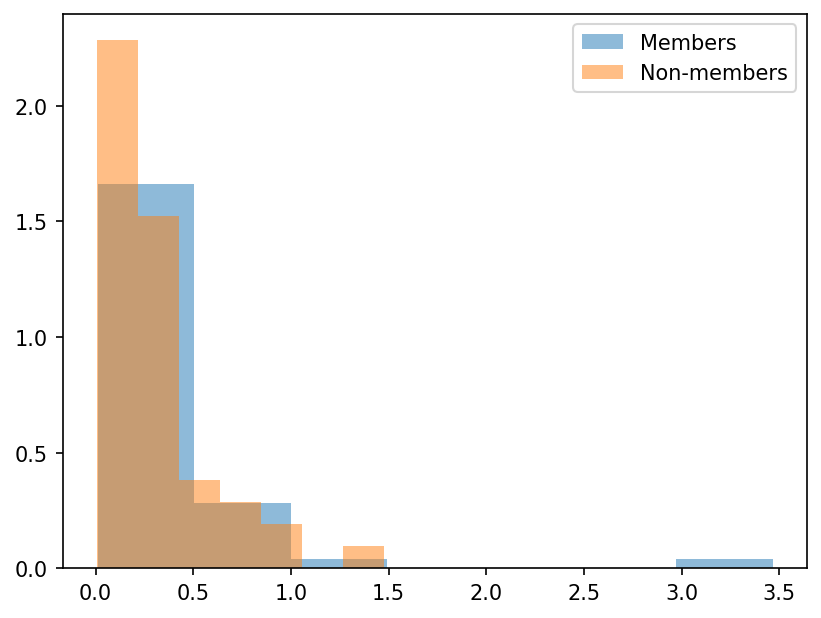

In [285]:
tfp = 3

plt.hist(losses_in[:, tfp], bins=7, label="Members", alpha=0.5, density=True)
plt.hist(losses_out[:, tfp], bins=7, label="Non-members", alpha=0.5, density=True)
plt.legend()
print()

In [302]:
from sklearn.tree import DecisionTreeClassifier

# Try training a meta-classifier on top of these metrics
num_test = 10
num_train = len(losses_in) - num_test

X_train = np.concatenate((losses_in[num_test:], losses_out[num_test:]), 0)
Y_train = np.array([1] * num_train + [0] * num_train)

X_test = np.concatenate((losses_in[:num_test], losses_out[:num_test]), 0)
Y_test = np.array([1] * num_test + [0] * num_test)

clf = DecisionTreeClassifier(max_depth=10)
clf.fit(X_train, Y_train)
print("Train:", clf.score(X_train, Y_train), "| Test:", clf.score(X_test, Y_test))

Train: 0.95 | Test: 0.5


In [ ]:
def recursive_to_device(data, device):
    return {key: value.to(device) for key, value in data.items()}

In [ ]:
model.to("cuda:0")

In [ ]:
def get_batch_metrics(m, features):
    wer_metric = evaluate.load("wer")

    input_features = [{"input_features": x} for x in features["input_features"]]
    batch = m.processor.feature_extractor.pad(input_features, return_tensors="pt")

    # get the tokenized label sequences
    label_features = [{"input_ids": x} for x in features["labels"]]
    # pad the labels to max length
    labels_batch = m.processor.tokenizer.pad(label_features, return_tensors="pt")

    # replace padding with -100 to ignore loss correctly
    labels = labels_batch["input_ids"].masked_fill(
    labels_batch.attention_mask.ne(1), -100)

    # if bos token is appended in previous tokenization step,
    # cut bos token here as it's append later anyways
    if (labels[:, 0] == m.processor.tokenizer.bos_token_id).all().cpu().item():
        labels = labels[:, 1:]

    batch["labels"] = labels
    
    # Get model output
    with ch.no_grad():
        batch_cuda = recursive_to_device(batch, "cuda:0")
        logits = m.model(**batch_cuda).logits.cpu()
        pred_ids = m.model.generate(**batch_cuda, max_length=225).cpu()
        label_ids = batch["labels"]

    # replace -100 with the pad_token_id
    label_ids[label_ids == -100] = model.tokenizer.pad_token_id

    # we do not want to group tokens when computing the metrics
    pred_str = model.tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
    pred_str = [x.lstrip().strip() for x in pred_str]
    label_str = model.tokenizer.batch_decode(label_ids, skip_special_tokens=True)
    
    wer = [wer_metric.compute(predictions=[x], references=[y]) for (x, y) in zip(pred_str, label_str)]
    for x, y in zip(pred_str, label_str):
        print(x)
        print(y)
        print()

    # Compute loss
    loss_function = ch.nn.CrossEntropyLoss()
    losses = [loss_function(x.view(-1, x.shape[-1]), y.view(-1)).item() for (x, y) in zip(logits, label_ids)]

    return wer, losses

In [ ]:
def get_metrics(m, data, batch_size: int = 8):
    all_metrics = []
    for i in tqdm(range(0, len(data), batch_size)):
        all_metrics.append(get_batch_metrics(m, data[i:i+batch_size]))
        break
    all_metrics = np.concatenate(all_metrics, 0).T
    return all_metrics

In [ ]:
# losses_members = get_metrics(model, subset_members)
losses_nonmembers = get_metrics(model, subset_nonmembers)

In [ ]:
losses_nonmembers[:, 0]

In [ ]:
# Plot loss values, WER, and CER for both scenarios
plt.hist(losses_members, 21, alpha=0.5, label="members")
plt.hist(losses_nonmembers, 21, alpha=0.5, label="non-members")
plt.legend()

In [ ]:
# Later: Consider adding noise/augmentations to input and measure robustness in model behavior